# In this notebook
- Randomized iterative methods (Gower's paper)
- Using them to linear solve matrices AX = B
- ADI 

All are tested very loosely with small matrices. A more formal unit test suite can be found in the project in `../src`.

In [148]:
# usings and imports
using Random
using LinearAlgebra
using SparseArrays
using Elliptic
using Plots


## Random iterative method (parameterized) 

Solves $Ax = b$

In [87]:
function rand_linsolve(A,b,B, Stype, seed=nothing,verbose=false)
    """
    Solves using randomized kaczmarz.
    Randomly selects a row per iteration to update x with
    
    INPUT:  matrix A mxn, 
            vector b mx1,
            matrix B nxn
            string Stype: "coordvec", ""
            
    OUTPUT: vector x nx1 that solves Ax = b
    """
    m,n = size(A)
    x0 = ones(n)
    sols = [x0] # list of x_0 ... x_n
    errs = zeros(0)
    if seed != nothing
        Random.seed!(seed)
    end
    @assert Stype == "coordvec"
    
    Binv = inv(B)
    xprev = x0
    while(true)
        
        i = rand(1:m)
        
        # S is a unit coordinate vector (temporary)
        S = zeros(m)
        S[i] = 1
        
        C = Binv * A' * S * pinv(S' * A * Binv * A' * S) * S'      
        res = A * xprev - b
        xnew = xprev - C * res
  
        push!(sols, xnew)
        err = norm(A * xnew - b)
        push!(errs,err)
        if err < 1e-5
            break
        end
        
        xprev = xnew
    end
    
    if verbose
        return sols,errs
    else
        return sols[end]
    end
end

rand_linsolve (generic function with 3 methods)

In [88]:
seed = 0

A = rand(Float64,30,50)
b = rand(Float64,30)
B = I # n x n 
# display("text/plain",A)
# display("text/plain",b)
# display("text/plain",B)

sols,errs = rand_linsolve(A,b, B,"coordvec", seed,true)
println("done")

done


In [89]:
println(size(errs))
# println(errs)
numiters= size(errs)[1]
plot(1:numiters, errs[:,1])

(14841,)


UndefVarError: UndefVarError: plot not defined

In [5]:
function rand_matsolve(A,B,seed=nothing)
    """
    Helper function that stacks together multiple Ax=b solvers
    INPUT: 
            A: matrix mxn
            B: matrix mxk
    OUTPUT: X: matrix such that AX = B
    """
    
    m1,n = size(A)
    m2,k = size(B)
    sol = zeros(n,k)
    @assert m1==m2 
    
    s(b) = rand_linsolve(A,b,I,"coordvec", seed)
    return mapslices(s,B,dims=[1])
    
end

rand_matsolve (generic function with 2 methods)

In [10]:
A = rand(Float64,30,50)
B = rand(Float64,30,60)
Bparam = I # n x n
m1,n = size(A)
m2,k = size(B)
sol = zeros(n,k)

X = rand_matsolve(A,B)
println("done")
println(norm(A * X - B))

done
7.679277571487114e-5


In [97]:
function adi_parameters(gamma,J)
    p = zeros(J)
    q = zeros(J)
    alpha = -1 + 2*gamma + 2 * sqrt(gamma^2 - gamma)
    kappa = sqrt(1 - 1 / (alpha^2))

    TT(t) = (-alpha * t -1)/(t + alpha)

    for j = 1:J
        z = (2 * j + 1) / (2 * J) * Elliptic.K(kappa)
        t = -alpha * Elliptic.Jacobi.dn(z,kappa)
        p[j] = TT(t)
        q[j] = TT(-t)
    end

    return p,q
end

adi_parameters (generic function with 2 methods)

## ADI

Solves $AX - XB = N$ for low rank $N$

In [98]:
function adi(A,B,F,N,p,q)
    m,m2 = size(A)
    n,n2 = size(B)
    
    @assert m==m2
    @assert n==n2
    
    sols = []
    Xprev = zeros((m,n)) 
    for i = 1:N
        Ahalf = (B - p[i] * I)
        Bhalf = (F - (A - p[i] * I)*Xprev)
        Xhalf = (Ahalf' \ Bhalf')'

        Asolve = (A - q[i] * I)
        Bsolve = F - Xhalf * (B - q[i] * I) 
        X = Asolve \ Bsolve
            
        Xprev = X 
        push!(sols,X)
    end    
    return sols
end

adi (generic function with 1 method)

In [252]:
# https://github.com/ajt60gaibb/freeLYAP/blob/master/iterative_solvers/getshifts_adi.m
#--- Small Test
temp = rand(5,5)
Q,R = qr(temp)
Q2,R2 = qr(rand(5,5))
Aevals = [1., 2., 3., 4., 5.]
# Bevals = [11., 12., 13., 14., 15.]
Bevals = -Aevals
A = Q * Diagonal(Aevals) * Q'
B = Q2 * Diagonal(Bevals) * Q2'
Xans = rand(5,5)
F = A * Xans - Xans * B

a = minimum(Aevals)
b = maximum(Aevals)
c = minimum(Bevals)
d = maximum(Bevals)
gamma = abs(((c-a)*(d-b))/ ((c-b)*(d-a)))
e = 10e-17
J = 1 + trunc(Int, abs(log(16 * gamma) * log(4 / e)  / pi^2))

14

In [253]:
#--- Run Small Test
p,q = adi_parameters(gamma, J)
sols = adi(A,B,F,J,p,q)
X = sols[end]
println(p)
println(q)
println(gamma)
#---

[75.1644, 26.4777, 13.0785, 7.58078, 4.81532, 3.24315, 2.27599, 1.64986, 1.23238, 0.951814, 0.767262, 0.655004, 0.601839, 0.601839]
[-2.52593, -2.40191, -2.23262, -2.03423, -1.82323, -1.61423, -1.4187, -1.24466, -1.09702, -0.978294, -0.889411, -0.830417, -0.801034, -0.801034]
1.8


2.1363396242031962e-10


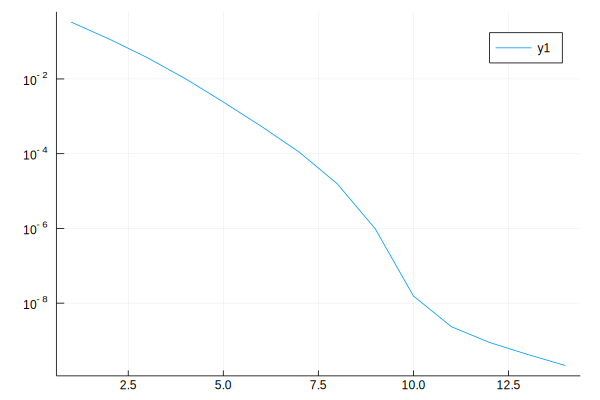

In [254]:
errs = zeros(J)
for j = 1:J
    errs[j] = norm(Xans - sols[j])/norm(Xans)
end
println(errs[end])
plot(errs, yaxis=:log)


In [214]:
@time ( X = adi(A,B,F,J,p,q)[end])

  0.000632 seconds (586 allocations: 120.047 KiB)


5×5 Array{Float64,2}:
 0.60593    0.490893  0.128785  0.443684  0.309254
 1.25013    0.95241   0.389248  0.479139  0.341305
 1.00946    1.91146   0.445838  0.967346  0.605525
 0.115655   0.435455  0.385542  0.78495   0.263608
 0.268121  -0.652115  0.499053  0.183377  0.227925

In [215]:
@time Xcon = sylvester(A,-1 .* B,-1 .* F)

  0.000116 seconds (35 allocations: 7.438 KiB)


5×5 Array{Float64,2}:
 0.487878  0.906489    0.103117  0.183143  0.556758 
 0.774915  0.882764    0.228974  0.853652  0.436912 
 0.9978    0.938658    0.659623  0.675108  0.291431 
 0.79438   0.115717    0.685151  0.437265  0.0261749
 0.623682  0.00306229  0.60842   0.315713  0.4214   

In [216]:
norm(Xcon - Xans)/norm(Xans)

1.7332031187141917e-15

In [217]:
@time adi(A,B,F,N,p,q)

  0.000399 seconds (61 allocations: 11.719 KiB)


3-element Array{Any,1}:
 [-0.0110871 -0.0175018 … -0.00523888 -0.0102958; -0.0216156 -0.0198263 … -0.0217807 -0.0105479; … ; -0.0198421 -0.000861244 … -0.0102923 0.00118843; -0.019877 -0.00170121 … -0.0109108 -0.00983775]
 [-0.0240488 -0.03786 … -0.0113896 -0.022267; -0.0469868 -0.0429341 … -0.0472829 -0.0228612; … ; -0.0430626 -0.00181625 … -0.0223168 0.00262961; -0.0432555 -0.00368516 … -0.0237514 -0.0213028]     
 [-0.0400047 -0.0627728 … -0.0189982 -0.0369093; -0.0783631 -0.0712757 … -0.0787309 -0.0379915; … ; -0.0716799 -0.00291722 … -0.0371067 0.00447826; -0.0722359 -0.00611852 … -0.0396797 -0.035363]   

final error, 2.0276250583521207e6


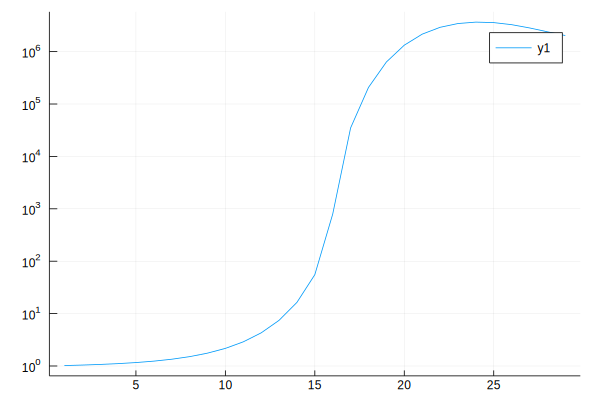

In [218]:
# med test

#--- med Test
temp = rand(50,50)
Q,R = qr(temp)
Aevals = [0.1:0.1:5;]
Bevals = [10.1:0.1:15;]
A = Q * Diagonal(Aevals) * Q'
B = Q * Diagonal(Bevals) * Q'
Xans = rand(50,50)
F = A * Xans - Xans * B

a = minimum(Aevals)
b = maximum(Aevals)
c = minimum(Bevals)
d = maximum(Bevals)
gamma = abs((c-a) * (d-b)  / (c-b)*(d-a))
e = 10e-15
J = 1 + trunc(Int, abs(log(16 * gamma) * log(4 / e)  / pi^2))
#--- Run med Test
p,q = adi_parameters(gamma, J)
sols = adi(A,B,F,J,p,q)
X = sols[end]
#---

errs = zeros(J)
for j = 1:J
    errs[j] = norm(Xans - sols[j])/norm(Xans)
end
println("final error, " ,errs[end])
plot(errs, yaxis=:log)


In [236]:
@time Xcon = sylvester(A,-1 .* B,-1 .* F)
@time X = adi(A,B,F,N,p,q)[end]

  0.003793 seconds (46 allocations: 287.422 KiB)
  0.055848 seconds (98 allocations: 730.172 KiB)


50×50 Array{Float64,2}:
 -0.00932915  -0.0188889   -0.0598534   …  -0.0497392   -0.0620034 
 -0.0172839   -0.0447723   -0.0623085       0.00230715  -0.0542316 
  0.00105069  -0.0571488   -0.0437746      -0.00804887  -0.0684998 
 -0.0443053   -0.0560349   -0.0353941      -0.0255017   -0.0225611 
 -0.0598235   -0.0483848   -0.0561527      -0.0457996   -0.020633  
 -0.0487406   -0.0634769   -0.0545173   …  -0.0631921   -0.0282794 
 -0.0479777   -0.0258949   -0.0548671      -0.0351758   -0.00375815
 -0.0394758   -0.0618212   -0.0193005      -0.0708079   -0.0100852 
 -0.0241351   -0.0463384   -0.0448103      -0.0125736   -0.0149665 
 -0.0406702   -0.00459396  -0.0431018      -0.00462839  -0.0565527 
 -0.0100522   -0.0344351   -0.00633881  …  -0.0550611   -0.0708883 
 -0.0196233   -0.00470618  -0.0458705      -0.0686338   -0.0577069 
 -0.0640611   -0.0528395   -0.0132402      -0.0450301   -0.0411755 
  ⋮                                     ⋱                          
 -0.00504382  -0.0419857

Wonder why the time fluctuates so much